In [1]:
from typing import Callable, List

import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import scipy.stats

In [2]:
class LinearPolicy:
    def __init__(
        self, parameters: np.ndarray, features: Callable[[np.ndarray], np.ndarray]
    ):
        """
        Linear Policy Constructor.
        
        Args:
            parameters (np.ndarray): policy parameters as np.ndarray.
            features (np.ndarray): features to be extracted from the state representation.
        """
        self._parameters = parameters
        self._features = features

    def __call__(self, state: np.ndarray) -> np.ndarray:
        """
        Call method of the Policy.
        
        Args:
            state (np.ndarray): environment state.
        
        Returns:
            The resulting action.
        """

        # calculate state features
        state_features = self._features(state)

        # the parameters shape [0] should be the same as the state features
        # as they must be multiplied
        assert state_features.shape[0] == self._parameters.shape[0]

        # dot product between parameters and state features
        return np.dot(self._parameters.T, state_features)

In [3]:
# sample a random set of parameters
parameters = np.random.rand(5, 1)

# define the state features as identity function
features = lambda x: x

# define the policy
pi: LinearPolicy = LinearPolicy(parameters, features)

# sample a state
state = np.random.rand(5, 1)

# Call the policy obtaining the action
action = pi(state)

print(action)

[[1.33244481]]


In [4]:
class GaussianPolicy:
    def __init__(
        self,
        mu_parameters: np.ndarray,
        sigma_parameters: np.ndarray,
        features: Callable[[np.ndarray], np.ndarray],
    ):
        """
        Linear Policy Constructor.
        
        Args:
            mu_parameters (np.ndarray): policy parameters of the mean (\mu) as np.ndarray.
            sigma_parameters (np.ndarray): policy parameters of the standard deviation as np.ndarray.
            features (np.ndarray): features to be extracted from the state representation.
        """
        self._mu_parameters = mu_parameters
        self._sigma_parameters = sigma_parameters
        self._features = features

    def __call__(self, state: np.ndarray) -> np.ndarray:
        """
        Call method of the Policy.
        
        Args:
            state (np.ndarray): environment state.
        
        Returns:
            The action sampled from the policy distribution.
        """

        # calculate state features
        state_features = self._features(state)

        # the parameters shape [0] should be the same as the state features
        # as they must be multiplied
        assert state_features.shape[0] == self._mu_parameters.shape[0]
        assert state_features.shape[0] == self._sigma_parameters.shape[0]

        # dot product between parameters and state features
        # \mu is the mean of the gaussian
        mu = np.dot(self._mu_parameters.T, state_features)
        # the stddev (sigma) should be squared to avoid negative numbers
        sigma = np.dot(self._sigma_parameters.T, state_features) ** 2

        # sample action from gaussian distribution
        action = np.random.normal(mu, sigma)

        return action

    def mu(self, state: np.ndarray) -> np.ndarray:
        """
        Mean of the distribution in the current state.
        
        Args:
            state (np.ndarray): environment state.
        
        Returns:
            mu: mean of the Gaussian distribution.
        """
        # calculate state features
        state_features = self._features(state)

        # the parameters shape [0] should be the same as the state features
        # as they must be multiplied
        assert state_features.shape[0] == self._mu_parameters.shape[0]

        return np.dot(self._mu_parameters.T, state_features)

    def sigma(self, state: np.ndarray) -> np.ndarray:
        """
        Stddev of the distribution in the current state.
        
        Args:
            state (np.ndarray): environment state.
            
        Returns:
            sigma: stddev of the Gaussian distribution.
        """
        # calculate state features
        state_features = self._features(state)

        # the parameters shape [0] should be the same as the state features
        # as they must be multiplied
        assert state_features.shape[0] == self._sigma_parameters.shape[0]

        return np.dot(self._sigma_parameters.T, state_features)

In [5]:
# sample a random set of parameters
mu_parameters = np.random.rand(5, 1)
sigma_parameters = np.random.rand(5, 1)

# define the state features as identity function
features = lambda x: x

# define the policy
pi: GaussianPolicy = GaussianPolicy(mu_parameters, sigma_parameters, features)

# sample a state
state = np.random.rand(5, 1)

# Call the policy obtaining the action
action = pi(state)

print(action)

[[5.80702857]]


In [6]:
%matplotlib inline

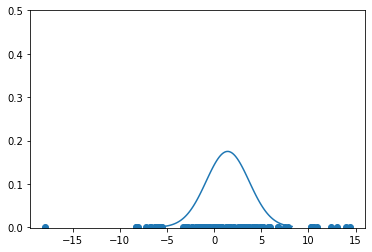

In [7]:
n_samples = 100

samples = []

# sample action from the policy and append them to the samples array
for _ in range(n_samples):
    samples.append(pi(state).flatten()[0])

# reduce the plot size
plt.ylim(-1e-3, 0.5)
# plot the samples on the x axis
plt.scatter(samples, np.zeros_like(samples))

# plot the distribution
mu = pi.mu(state).flatten()[0]
sigma = pi.sigma(state).flatten()[0]
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma))

In [8]:
class BoltzmannPolicy:
    def __init__(
        self, parameters: List[np.ndarray], features: Callable[[np.ndarray], np.ndarray]
    ):
        """
        Linear Policy Constructor.
        
        Args:
            parameters (List[np.ndarray]): policy parameters for each action as np.ndarray.
            features (np.ndarray): features to be extracted from the state representation.
        """
        self._parameters = parameters
        self._features = features
        self._n_actions = len(self._parameters)

    def __call__(self, state: np.ndarray) -> np.ndarray:
        """
        Call method of the Policy.
        
        Args:
            state (np.ndarray): environment state.
            
        Returns:
            action: Action sampled from the action probabilities.
        """

        # calculate state features
        state_features = self._features(state)

        # the parameters shape [0] should be the same as the state features
        # as they must be multiplied
        for action_params in self._parameters:
            assert state_features.shape[0] == action_params.shape[0]

        # calculate scores for each action
        scores = []
        for action_params in self._parameters:
            score = np.dot(action_params.T, state_features)[0, 0]
            scores.append(score)

        # use scipy softmax function
        action_probs = scipy.special.softmax(scores)

        # sample the action according to the probabilities
        action = np.random.choice(self._n_actions, p=action_probs)

        return action

In [9]:
n_actions = 3
# sample a random set of parameters for each action
parameters = [np.random.rand(5, 1) for _ in range(n_actions)]

# define the state features as identity function
features = lambda x: x

# define the policy
pi: BoltzmannPolicy = BoltzmannPolicy(parameters, features)

# sample a state
state = np.random.rand(5, 1)

# Call the policy obtaining the action
action = pi(state)
print("Selected Action is", action)

# sample some actions
for _ in range(10):
    print("Selected action is", pi(state))

Selected Action is 1
Selected action is 1
Selected action is 2
Selected action is 1
Selected action is 0
Selected action is 2
Selected action is 2
Selected action is 1
Selected action is 0
Selected action is 0
Selected action is 1
